In [1]:
import numpy as np
import os
import pandas
import datetime
import matplotlib.pyplot as plt
import world_bank_data as wb
import seaborn as sns; sns.set_theme()
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [3]:
def plot_kmeans_clusters(x_column, y_column, df, clusters_data):
    colors = cm.nipy_spectral(clusters_data.labels_.astype(float) / len(clusters_data.cluster_centers_))

    x = df[x_column]
    y = df[y_column]

    plt.scatter(x, y, marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusters_data.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(centers[:, df.columns.get_loc(x_column)],
                centers[:, df.columns.get_loc(y_column)],
                marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        plt.scatter(c[df.columns.get_loc(x_column)],
                    c[df.columns.get_loc(y_column)],
                    marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    
    plt.show()

# Prepare data

In [4]:
df1 = pandas.read_excel("../Wzorcowe_dane/lab1_result_v3.xlsx")
df1

,Unnamed: 0,index,countriesAndTerritories,countryterritoryCode,continentExp,october_cases_total_per100k,october_deaths_total_per100k,november_cases_%,november_deaths_%,avgTemp,PKB,PopDen_2018,HospBeds,doctors_per1k,pop_age65,traf_victims_per1k,pollution,total_tests_per_thousand,health_expandiure
0,0,0,Afghanistan,AFG,Asia,16.161188,0.733405,0.646877,0.720430,16.013610,502.115487,56.937760,0.5,0.2782,2.615794,1510.0,56.910808,NaN,11.777194
1,1,339,Albania,ALB,Europe,771.443254,12.891158,0.677747,0.680217,14.712429,5352.857411,104.612263,2.9,1.2164,14.202631,1360.0,18.200603,NaN,NaN
2,2,619,Algeria,DZA,Africa,64.436776,1.454020,0.773520,0.632588,26.081716,3948.343279,17.730075,1.9,1.7193,6.552778,2380.0,38.884011,NaN,6.374322
3,3,963,Andorra,AND,Europe,5996.560642,30.192840,0.409151,0.043478,NaN,40886.391165,163.842553,2.5,3.3333,NaN,760.0,10.307621,NaN,10.320552
4,4,1238,Angola,AGO,Africa,31.157602,0.505887,0.459056,0.403727,22.684573,2973.591160,24.713052,0.8,0.2146,2.199342,2360.0,32.388505,NaN,2.791500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,207,60266,Vietnam,VNM,Asia,0.245692,0.000000,0.649789,0.000000,25.337671,2715.276036,308.125246,2.6,0.8281,7.553673,2640.0,29.626728,12.953,5.532128
208,208,60669,Western_Sahara,ESH,Africa,0.000000,0.000000,0.000000,0.000000,26.468866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,209,60901,Yemen,YEM,Asia,0.133736,0.054866,0.282051,0.250000,24.572179,968.159048,53.977853,0.7,0.5251,2.902141,2150.0,50.456007,NaN,4.234575
210,210,61149,Zambia,ZMB,Africa,15.889338,0.139970,0.400987,0.320000,23.793276,1291.343357,23.341479,2.0,1.1867,2.115315,2470.0,27.438035,24.777,4.470341


In [5]:
df_new_sick = df1.copy()
df_new_sick = df_new_sick.drop(columns=[
    "Unnamed: 0",
    "index",
    "countriesAndTerritories",
    "countryterritoryCode",
    "continentExp",
    "avgTemp",
    "PKB",
    "PopDen_2018",
    "HospBeds",
    "doctors_per1k",
    "pop_age65",
    "traf_victims_per1k",
    "pollution",
    "total_tests_per_thousand",
    "health_expandiure",
])
df_new_sick

,october_cases_total_per100k,october_deaths_total_per100k,november_cases_%,november_deaths_%
0,16.161188,0.733405,0.646877,0.720430
1,771.443254,12.891158,0.677747,0.680217
2,64.436776,1.454020,0.773520,0.632588
3,5996.560642,30.192840,0.409151,0.043478
4,31.157602,0.505887,0.459056,0.403727
...,...,...,...,...
207,0.245692,0.000000,0.649789,0.000000
208,0.000000,0.000000,0.000000,0.000000
209,0.133736,0.054866,0.282051,0.250000
210,15.889338,0.139970,0.400987,0.320000


# Statistics

In [6]:
df_ready_data_numeric_sum = pandas.DataFrame(df1.isnull().sum(), columns = ["missing"])
df_ready_data_numeric_max = pandas.DataFrame(df1.max(), columns = ["max"])
df_ready_data_numeric_min = pandas.DataFrame(df1.min(), columns = ["min"])
df_ready_data_numeric_mean = pandas.DataFrame(df1.mean(), columns = ["mean"])
df_ready_data_numeric_median = pandas.DataFrame(df1.median(), columns = ["median"])
df_ready_data_numeric_std = pandas.DataFrame(df1.std(), columns = ["std"])

frames = [df_ready_data_numeric_sum,
         df_ready_data_numeric_max,
         df_ready_data_numeric_min,
         df_ready_data_numeric_mean,
         df_ready_data_numeric_median,
         df_ready_data_numeric_std]

df_statistics = pandas.concat(frames, axis=1)
df_statistics

,missing,max,min,mean,median,std
Unnamed: 0,0,211,0,105.500000,105.500000,61.343296
index,0,61419,0,30969.268868,31206.500000,17918.261657
countriesAndTerritories,0,Zimbabwe,Afghanistan,NaN,NaN,NaN
countryterritoryCode,0,ZWE,ABW,NaN,NaN,NaN
continentExp,0,Oceania,Africa,NaN,NaN,NaN
october_cases_total_per100k,0,5996.56,0,637.598364,127.764624,985.219506
october_deaths_total_per100k,0,67.0717,0,7.947889,1.203586,12.394477
november_cases_%,0,1,0,0.532542,0.524199,0.191782
november_deaths_%,0,1,0,0.461380,0.489340,0.318782
avgTemp,41,30.771,-0.452322,19.910217,22.823381,7.283709


# Clustering - only covid data

## automatic n clusters

In [7]:
clustering_sick = AgglomerativeClustering().fit(df_new_sick)
clustering_sick.labels_

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

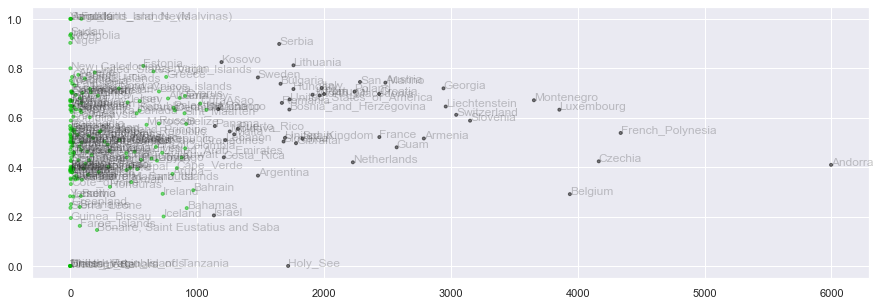

In [8]:
#%matplotlib notebook
colors = cm.nipy_spectral(clustering_sick.labels_.astype(float) / clustering_sick.n_clusters_)
plt.scatter(df_new_sick["october_cases_total_per100k"], df_new_sick["november_cases_%"], alpha=0.5, c=colors, marker='.')
for i, txt in enumerate(df1.countriesAndTerritories):
    plt.annotate(txt, (df_new_sick["october_cases_total_per100k"][i], df_new_sick["november_cases_%"][i]), alpha=0.25)

### 3 clusters

In [9]:
clustering_sick = AgglomerativeClustering(n_clusters=3).fit(df_new_sick)
clustering_sick.labels_

array([0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

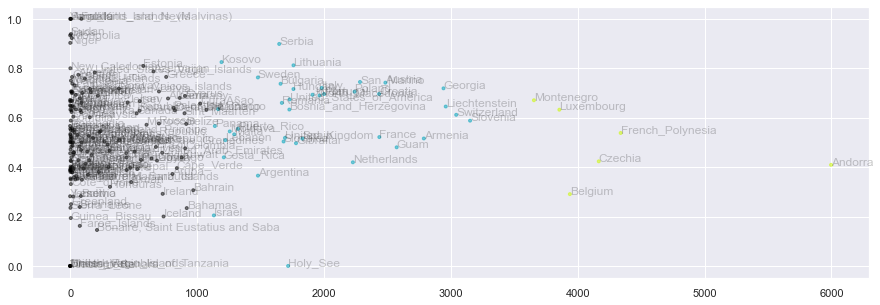

In [10]:
#%matplotlib notebook
colors = cm.nipy_spectral(clustering_sick.labels_.astype(float) / clustering_sick.n_clusters_)
plt.scatter(df_new_sick["october_cases_total_per100k"], df_new_sick["november_cases_%"], alpha=0.5, c=colors, marker='.')
for i, txt in enumerate(df1.countriesAndTerritories):
    plt.annotate(txt, (df_new_sick["october_cases_total_per100k"][i], df_new_sick["november_cases_%"][i]), alpha=0.25)

## dendrogram

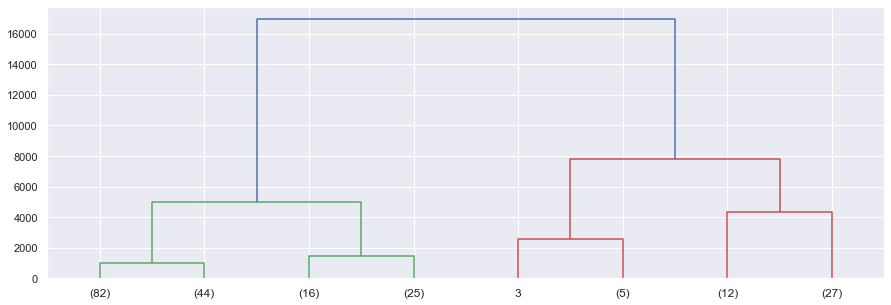

In [11]:
clustering_sick = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(df_new_sick)
plot_dendrogram(clustering_sick, truncate_mode='level', p=2)

# Kmeans

In [12]:
from sklearn.cluster import KMeans

kmeans_sick = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=43)

clusters_data_sick = kmeans_sick.fit(df_new_sick)

### only covid data

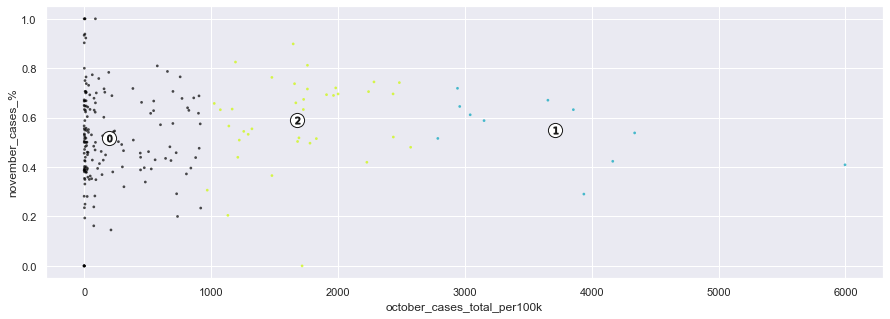

In [13]:
plot_kmeans_clusters("october_cases_total_per100k", "november_cases_%", df_new_sick, clusters_data_sick)

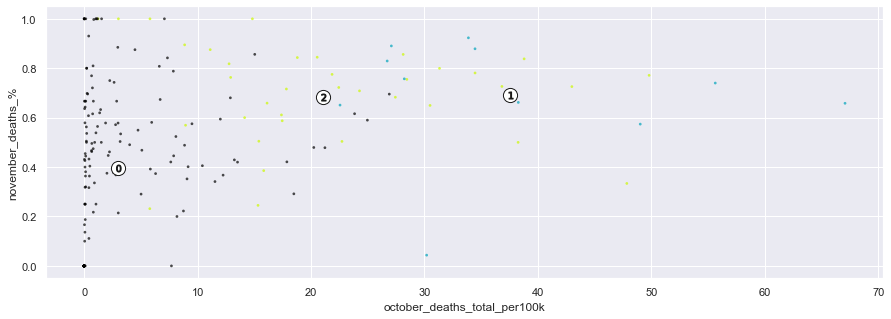

In [14]:
plot_kmeans_clusters("october_deaths_total_per100k", "november_deaths_%", df_new_sick, clusters_data_sick)

In [15]:
df_sick_centers = pandas.DataFrame(clusters_data_sick.cluster_centers_)
df_sick_centers.columns = df_new_sick.columns
df_sick_centers

,october_cases_total_per100k,october_deaths_total_per100k,november_cases_%,november_deaths_%
0,196.148517,2.997728,0.518586,0.395924
1,3712.217182,37.554295,0.549433,0.691469
2,1680.219120,21.087241,0.589378,0.683107


# Calinski-Harabasz

In [16]:
len(df_new_sick.index) - 2

210

In [17]:
from sklearn.metrics import calinski_harabasz_score
from random import randrange
from statistics import mean

c_h_score = []

for x in range(2, len(df_new_sick.index) - 2):
    c_h_score_sub = []
    for sub_x in range(1,2):
        kmeans_sick = KMeans(
            init="random",
            n_clusters=x,
            n_init=10,
            max_iter=300,
            random_state=randrange(100000))
        clusters_data_sick = kmeans_sick.fit(df_new_sick)
        c_h_score_sub.append(calinski_harabasz_score(df_new_sick, clusters_data_sick.labels_))

    c_h_score.append(mean(c_h_score_sub))

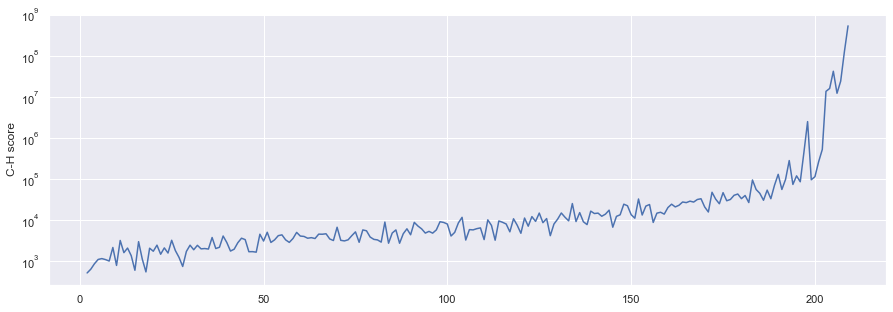

In [18]:
plt.plot(range(2, len(df_new_sick.index) - 2), c_h_score)
plt.ylabel('C-H score')
plt.yscale('log')
plt.show()

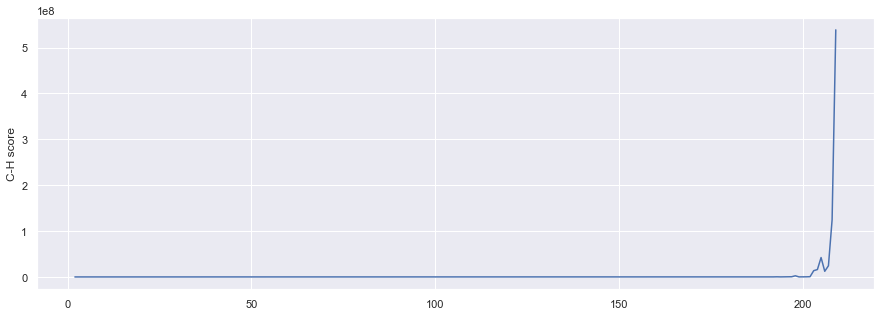

In [19]:
plt.plot(range(2, len(df_new_sick.index) - 2), c_h_score)
plt.ylabel('C-H score')
plt.show()

In [20]:
c_h_score = []

for x in range(2, 100):
    c_h_score_sub = []
    for sub_x in range(1,100):
        kmeans_sick = KMeans(
            init="random",
            n_clusters=x,
            n_init=10,
            max_iter=300,
            random_state=randrange(100000))
        clusters_data_sick = kmeans_sick.fit(df_new_sick)
        c_h_score_sub.append(calinski_harabasz_score(df_new_sick, clusters_data_sick.labels_))

    c_h_score.append(mean(c_h_score_sub))

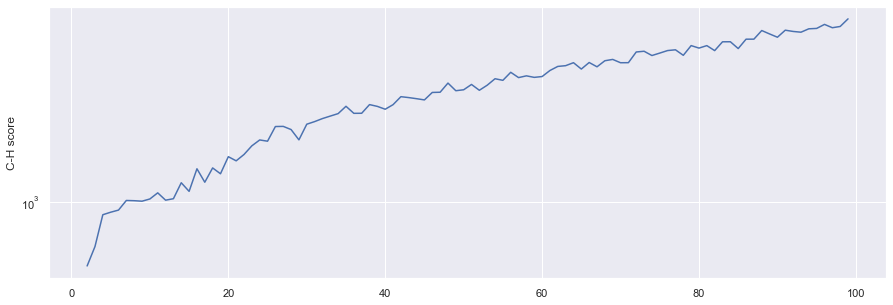

In [21]:
plt.plot(range(2, 100), c_h_score)
plt.ylabel('C-H score')
plt.yscale('log')
plt.show()

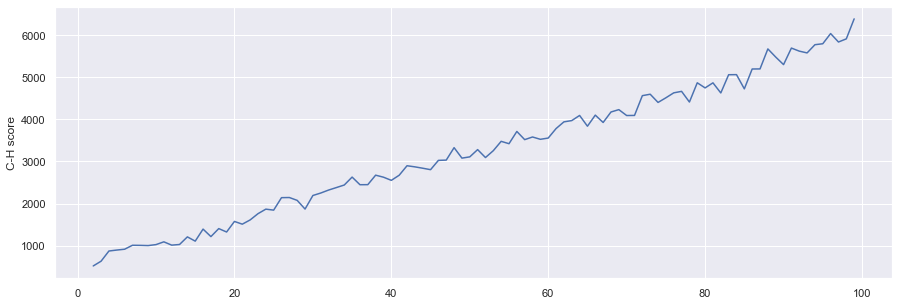

In [22]:
plt.plot(range(2, 100), c_h_score)
plt.ylabel('C-H score')
plt.show()